## Convex Optimization Final Project
### Milad Heidari
### Student Number: 98101469
### Instructor: Dr. M. Babazadeh
$\newline$


### Importing Required Modules

Make sure you have installed all the packages listed in "requirements.txt" file before running this notebook.

In [1]:
!pip install -r ./requirements.txt

In [2]:
import time
import jdc
import numpy as np
import cvxpy as cp
import pandas as pd
import matplotlib.pyplot as plt
import tqdm.notebook as tq

### Reading Data From the File

The "svm_train.txt" file contains 863 two-dimensional points. Each line in the file represents a point and the group it belongs to (labels are either 1 or -1). Note that the "line x1, x2, y" is added to the first line of the file to display column names.

In [3]:
df = pd.read_csv('svm_train.txt', delim_whitespace=True)

In [4]:
df

,x1,x2,y
0,0.107143,0.603070,1
1,0.093318,0.649854,1
2,0.097926,0.705409,1
3,0.155530,0.784357,1
4,0.210829,0.866228,1
...,...,...,...
858,0.994240,0.516667,1
859,0.964286,0.472807,1
860,0.975806,0.439474,1
861,0.989631,0.425439,1


In [5]:
X = df[['x1', 'x2']].to_numpy()
y = df['y'].to_numpy()

In [6]:
print(X.shape)
print(y.shape)

(863, 2)
(863,)


### Visualizing the Dataset

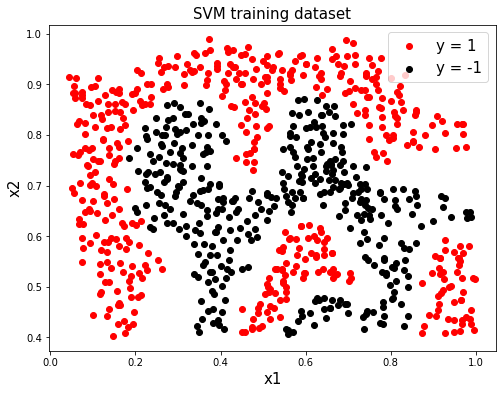

In [7]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)

positive_x = X[y == 1]
negative_x = X[y == -1]

ax.scatter(positive_x[:, 0], positive_x[:, 1], color='red', label='y = 1')
ax.scatter(negative_x[:, 0], negative_x[:, 1], color='black', label='y = -1')

ax.set_xlabel('x1', fontsize=15)
ax.set_ylabel('x2', fontsize=15)

ax.set_title('SVM training dataset', fontsize=15)

ax.legend(fontsize=15)

plt.show();

In order to train different models on data, we create a class for SVM with empty methods and later, as we derive the formulas, we define methods' bodies.

In [8]:
class SVM:
    
    def __init__(self, X, y, gamma=0, C=0, error=1e-5):
        self.X = X
        self.y = y
        self.gamma = gamma
        self.C = C
        self.b = None
        self.prob = None
        self.alpha = None
        self.error = error
        self.training_time = None
        self.optimal_cost = float('inf')
        self.num_support_vectors = 0
        
    @staticmethod
    def RBF_kernel(x1, x2, gamma):
        return np.exp(-gamma * np.linalg.norm(x1 - x2) ** 2)
    
    def train_cvx(self, verbose=False):
        pass
    
    def plot_boundary(self):
        pass
    
    def train_accuracy(self):
        pass
    
    def predict(self, x):
        pass
    

### Training the Model

The primal optimization problem we try to solve is:

$$
\begin{aligned}
\textbf{minimize} \ \ \ & \frac{1}{2} ||w||_2^2 + C \sum_{i=1} ^{n} \zeta_i \\
\textbf{subject to} \ \ \ & \zeta_i \geq 0, \ \ i=1,...,n, \\
& y_i(w^Tx_i+b) \geq 1-\zeta_i, \ \ i=1,...,n
\end{aligned}
$$

$\newline$

In the case we don't use any kernel, the dual problem is representable as below:

$$
\begin{aligned}
\textbf{maximize} \ \ \ & -(1/2)\alpha^T\tilde{X}\tilde{X}^T\alpha + \textbf{1}^T\alpha \\ 
\textbf{subject to} \ \ \ & \alpha^Ty=0, \\
& 0 \leq \alpha \leq C\textbf{1}
\end{aligned}
$$

where $\tilde{X} = diag(y)X$.

$\newline$

In presence of RBF kernel, we can formulate dual problem as below: 

First we define a new vector $z\in R^n$:
$$
z = 
\begin{bmatrix}
x_1^Tx_1 \\
x_2^Tx_2 \\
... \\
x_n^Tx_n
\end{bmatrix}
= diag(XX^T)
$$

then we make $X_1 \in R^{n \times n}$ by repeating z, n times along columns axis:
$$
X_1 =
\begin{bmatrix}
z & z & ... & z \\
\end{bmatrix}
=
\begin{bmatrix}
x_1^Tx_1 & x_1^Tx_1 & ... & x_1^Tx_1\\
x_2^Tx_2 & x_2^Tx_2 & ... & x_2^Tx_2\\
... & ... & ... & ...\\
x_n^Tx_n & x_n^Tx_n & ... & x_n^Tx_n\\
\end{bmatrix}
$$

Now the matrix $X_2 = X_1 + X_1^T - 2XX^T$ consists of $||x_i - x_j||^2$ for every $(i,j)$ pair, because we have $||x-y||^2 = ||x||^2 + ||y||^2 - 2x^Ty$. So, 

$$
X_2 = 
\begin{bmatrix}
||x_1 - x_1||^2 & ||x_1 - x_2||^2 & ... & ||x_1 - x_n||^2 \\
||x_2 - x_1||^2 & ||x_2 - x_2||^2 & ... & ||x_2 - x_n||^2 \\
... & ... & ... & ... \\
||x_n - x_1||^2 & ||x_n - x_2||^2 & ... & ||x_n - x_n||^2 \\
\end{bmatrix}
$$

then we apply $f(x) = e^{-\gamma x}$ function on every element of $X_2$ to obtain $X_3$:

$$
X_3 =
\begin{bmatrix}
e^{-\gamma||x_1 - x_1||^2} & e^{-\gamma||x_1 - x_2||^2} & ... & e^{-\gamma||x_1 - x_n||^2} \\
e^{-\gamma||x_2 - x_1||^2} & e^{-\gamma||x_2 - x_2||^2} & ... & e^{-\gamma||x_2 - x_n||^2} \\
... & ... & ... & ... \\
e^{-\gamma||x_n - x_1||^2} & e^{-\gamma||x_n - x_2||^2} & ... & e^{-\gamma||x_n - x_n||^2} \\
\end{bmatrix}
$$

Now, we construct P by element-wise multiplication of $yy^T$ and $X_3$:

$$
P = yy^T .* \ X_3 = 
\begin{bmatrix}
y_1y_1e^{-\gamma||x_1 - x_1||^2} & y_1y_2e^{-\gamma||x_1 - x_2||^2} & ... & y_1y_ne^{-\gamma||x_1 - x_n||^2} \\
y_2y_1e^{-\gamma||x_2 - x_1||^2} & y_2y_2e^{-\gamma||x_2 - x_2||^2} & ... & y_2y_ne^{-\gamma||x_2 - x_n||^2} \\
... & ... & ... & ... \\
y_ny_1e^{-\gamma||x_n - x_1||^2} &y_ny_2e^{-\gamma||x_n - x_2||^2} & ... & y_ny_ne^{-\gamma||x_n - x_n||^2} \\
\end{bmatrix}
$$

Having P, we can formulate the dual problem as a QP optimization problem:

$$
\begin{aligned}
\textbf{maximize} \ \ \ & -(1/2)\alpha^TP\alpha + \textbf{1}^T\alpha \\ 
\textbf{subject to} \ \ \ & y^T\alpha=0, \\
& 0 \leq \alpha \leq C\textbf{1}
\end{aligned}
$$

Now we are ready to define the train method of the class. Note that %%add_to (class name) is a jupyter magic method that allows us to define components of a class in multiple cells.

In [9]:
%%add_to SVM
def train_cvx(self, verbose=False):
    n = len(self.y)
    alpha = cp.Variable(n)

    # constraints
    constr = [y.T @ alpha == 0,
              cp.min(alpha) >= 0,
              cp.max(alpha) <= C
             ]

    # objective function
    z = np.diag(self.X @ self.X.T).reshape(-1, 1)
    X1 = np.repeat(z, n, axis=1)
    X2 = X1 + X1.T - 2* self.X @ self.X.T
    X3 = np.exp(-gamma * X2)
    y1 = np.reshape(self.y, (-1, 1))
    P = (y1 @ y1.T) * X3

    P = cp.atoms.affine.wraps.psd_wrap(P)
    obj_func = - 0.5 * cp.quad_form(alpha, P) + np.ones((n, 1)).T @ alpha

    obj = cp.Maximize(obj_func)

    prob = cp.Problem(obj, constr)
    t_start = time.time()
    prob.solve();
    t_end = time.time()
    self.training_time = t_end - t_start


    if verbose:
        print(f'for C={self.C}, gamma={self.gamma}: ')
        print(f'Problem status: {prob.status}')
        print(f'Optimal value: {prob.value}')
        print(f'training accuracy: {self.train_accuracy()}')
        print(f'elapsed time: {self.training_time}')
        print()

    self.prob = prob
    self.alpha = alpha.value
    self.optimal_cost = prob.value

### Effect of Different Values of C and $\gamma$

Below we train a model for every combination of $C,\gamma$ values and print the results.

In [10]:
gamma_vals = [10, 50, 100, 500]
C_vals = [0.01, 0.1, 0.5, 1]
# gamma_vals = [500]
# C_vals = [0.1]
SVMs = {}

for C in C_vals:
    for gamma in gamma_vals:
        svm = SVM(X, y, gamma, C)
        SVMs[(C, gamma)] = svm
        svm.train_cvx(verbose=True)


for C=0.01, gamma=10: 
Problem status: optimal
Optimal value: 7.130305930812088
training accuracy: None
elapsed time: 2.106111526489258

for C=0.01, gamma=50: 
Problem status: optimal
Optimal value: 6.716284053828371
training accuracy: None
elapsed time: 2.2333950996398926

for C=0.01, gamma=100: 
Problem status: optimal
Optimal value: 6.794815928707368
training accuracy: None
elapsed time: 3.4110324382781982

for C=0.01, gamma=500: 
Problem status: optimal
Optimal value: 7.306537218401471
training accuracy: None
elapsed time: 2.769052743911743

for C=0.1, gamma=10: 
Problem status: optimal
Optimal value: 49.480754242562746
training accuracy: None
elapsed time: 2.471766471862793

for C=0.1, gamma=50: 
Problem status: optimal
Optimal value: 31.260609327930695
training accuracy: None
elapsed time: 2.257333993911743

for C=0.1, gamma=100: 
Problem status: optimal
Optimal value: 28.37418209486445
training accuracy: None
elapsed time: 3.2809839248657227

for C=0.1, gamma=500: 
Problem statu

C:\Users\Milad\anaconda3\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


for C=1, gamma=50: 
Problem status: optimal_inaccurate
Optimal value: 116.63474238187425
training accuracy: None
elapsed time: 6.507205247879028

for C=1, gamma=100: 
Problem status: optimal
Optimal value: 83.41143631202593
training accuracy: None
elapsed time: 5.841253280639648

for C=1, gamma=500: 
Problem status: optimal
Optimal value: 73.96326536408691
training accuracy: None
elapsed time: 4.297828912734985



### Making Prediction on New Data

Having optimal value of dual variable $\alpha$,as discussed in the class, when using no kernel, $w$ and $b$ of primal problem can be recovered as follows:

$$ w = \sum_{i=1}^n y_i\alpha_ix_i $$

And for recovering $b$, if we consider a margin support vector $x^*$ (a point that lies on the margin of the classifier), then we have:

$$ y_i(w^Tx_i+b)=1 $$

$$ b = \frac{1}{y_i} - w^Tx_i $$

If we get a new data point $x$, our algorithm classifies it as follows:
$$ \hat{y} = sign(w^Tx + b) = sign(\sum_{i=1}^n y_i\alpha_ix_i^Tx + b) $$

In presence of kernel, we simply replace the dot product of vectors with the kernel function:
$$ \hat{y} = sign(\sum_{i=1}^n y_i\alpha_iK(x_i, x) + b) $$

But the way we compute $b$ here is different from the above case. Considering any margin support vector $x^*$, $b$ is found as below:
$$ b = y^* - \sum_{i=1}^n \alpha_iy_iK(x^*, x_i) $$

In [11]:
%%add_to SVM

def predict(self, x):
    
    # finding a support vector
    if self.b is None:
        idx = np.where(np.logical_and(self.alpha > self.error, self.alpha < self.C-self.error))[0][0]
        x_star = X[[idx], :]
        B = np.linalg.norm(self.X - x_star, axis=1, keepdims=True) ** 2
        B = np.exp(-self.gamma * B)
        self.b = y[idx] - B.T @ (self.alpha * self.y)
    
    X1 = np.linalg.norm(self.X - x, axis=1, keepdims=True) ** 2
    X1 = np.exp(-self.gamma * X1)
    prediction = X1.T @ (self.alpha * self.y) + self.b
    return prediction

### Plotting Decision Boundary

The decision boundary is just the level-0 contour of $g(x) = \sum_{i=1}^n y_i\alpha_iK(x_i, x) + b$, since the prediction is made based on the values of this function. More precisely, if $g(x)$ evaluates to a negative number, then the point is considered as negative group ($\hat{y} = -1$) and positive group ($\hat{y} = 1$) otherwise.

In [12]:
%%add_to SVM

def plot_boundary(self, support_vectors=False):
            
    fig = plt.figure(figsize=(10, 7.5))
    ax = fig.add_subplot(1, 1, 1)
    
    # drawing decision boundary
    x_ = np.linspace(0, 1, 100)
    y_ = np.linspace(0, 1, 100)
    [x_, y_] = np.meshgrid(x_, y_)
    z = np.zeros(x_.shape)
    for i in range(100):
        for j in range(100):
            point = np.array([x_[i, j], y_[i,j]])
            z[i, j] = self.predict(point)
    
    cs = ax.contourf(x_, y_, z, alpha=0.25, cmap='Greys')
    plt.colorbar(cs)
    ax.contour(x_, y_, z, levels=[0], colors=['blue'], linewidths=[2])

    # Scattering data points
    
    positive_x = self.X[self.y == 1]
    negative_x = self.X[self.y == -1]

    ax.scatter(positive_x[:, 0], positive_x[:, 1], color='red', label='y = 1', s=30)
    ax.scatter(negative_x[:, 0], negative_x[:, 1], color='black', label='y = -1', s=30)
    
    title = f'Decision Boundary for C = {self.C}, gamma = {self.gamma}'
    
    # Scattering Support Vectors
    if support_vectors:
        sv_idx = np.where(self.alpha > self.error)[0]
        self.num_support_vectors = len(sv_idx)
        ax.scatter(X[sv_idx, 0], X[sv_idx, 1], color='blueviolet', label='Support Vector')
        title = f'C = {self.C}, gamma = {self.gamma}, Number of Support Vectors: {len(sv_idx)}'
        
    ax.set_xlabel('x1', fontsize=15)
    ax.set_ylabel('x2', fontsize=15)

    ax.set_title(title, fontsize=15)

    ax.legend(fontsize=15)

    plt.show()

<string>:18: UserWarning: No contour levels were found within the data range.


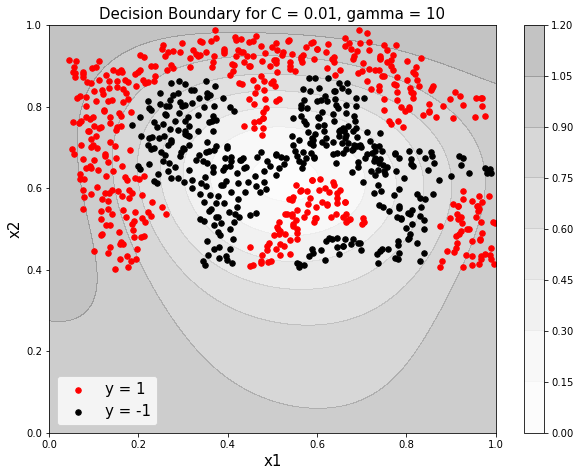

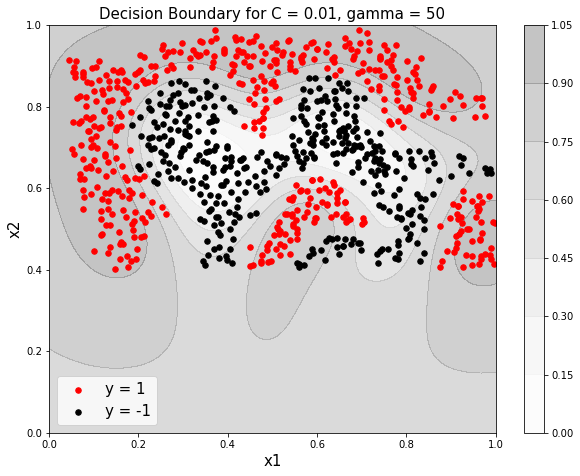

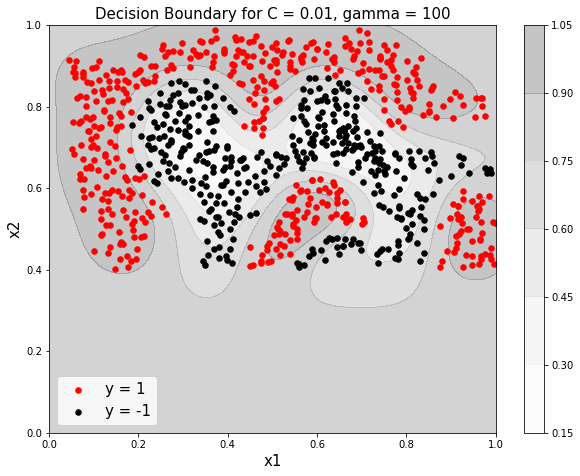

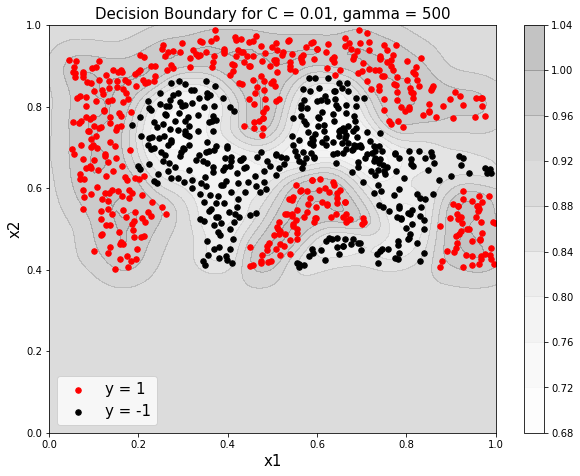

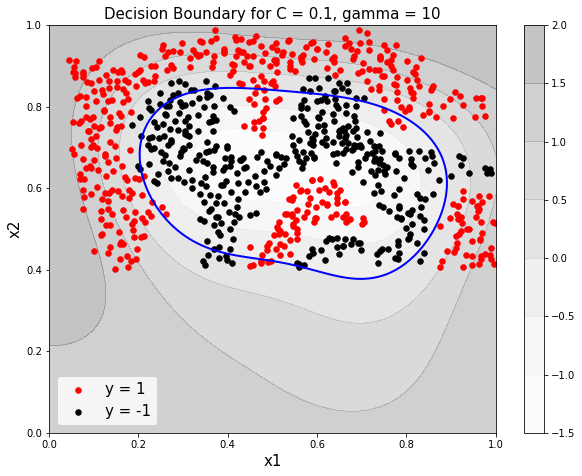

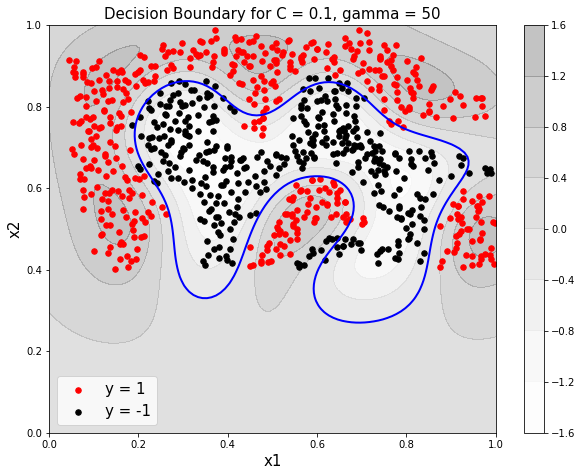

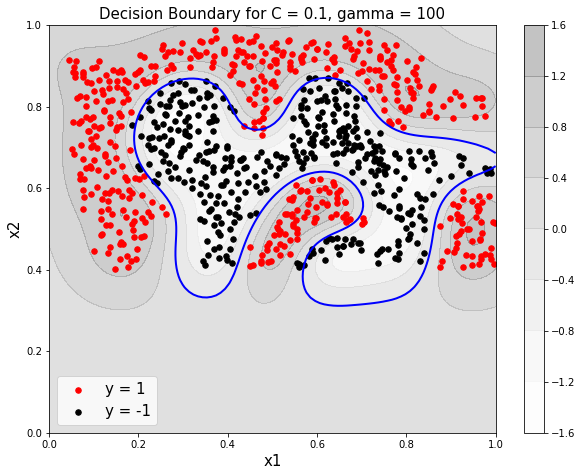

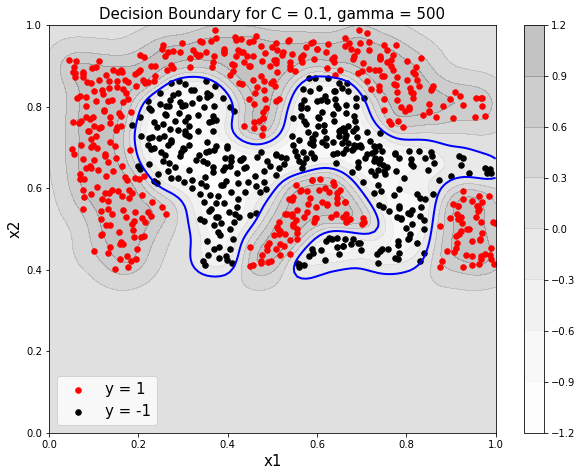

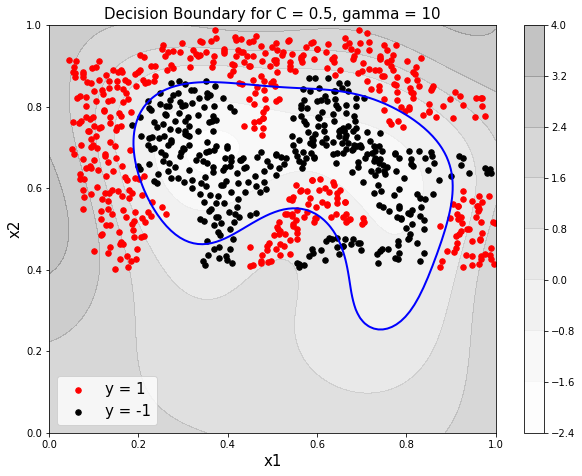

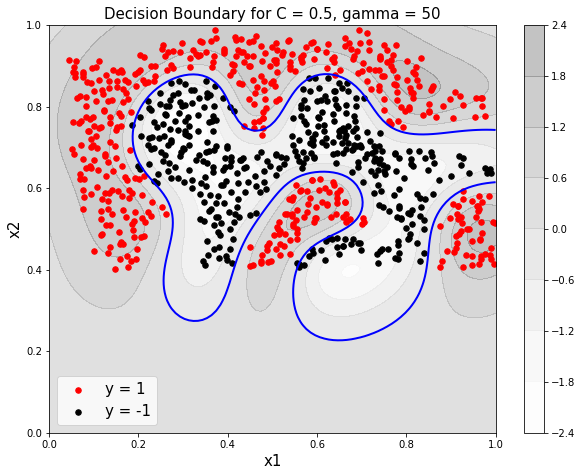

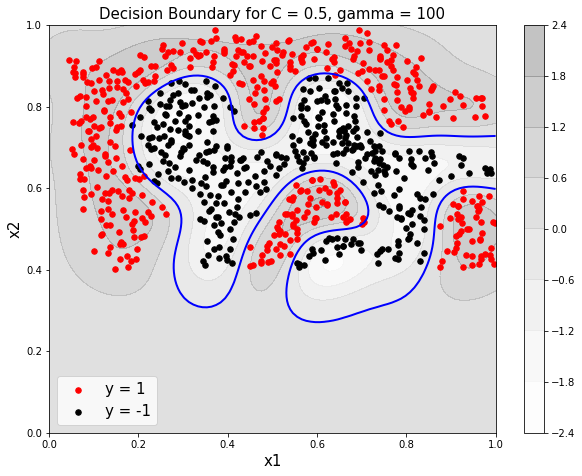

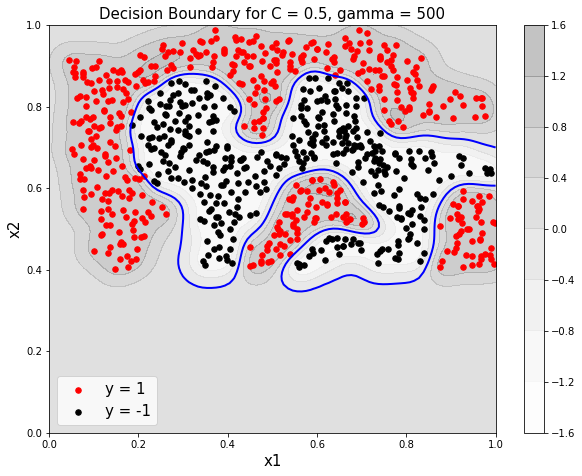

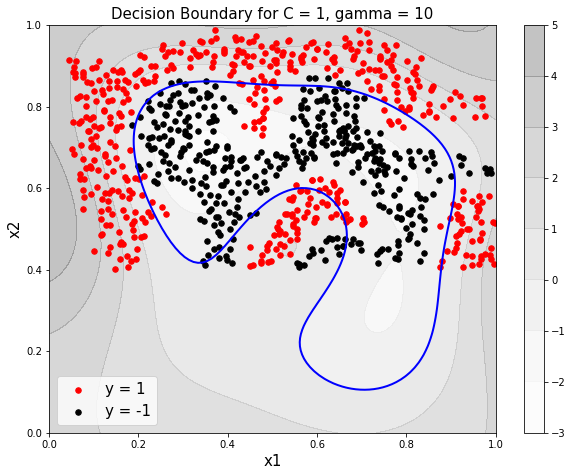

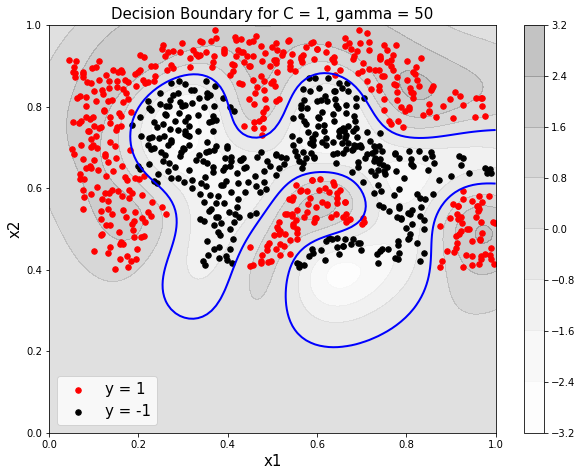

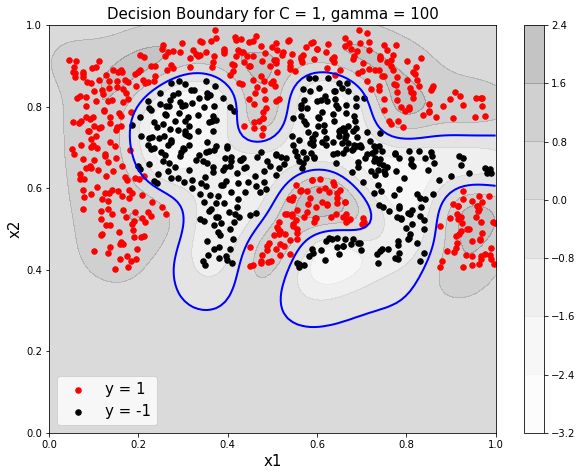

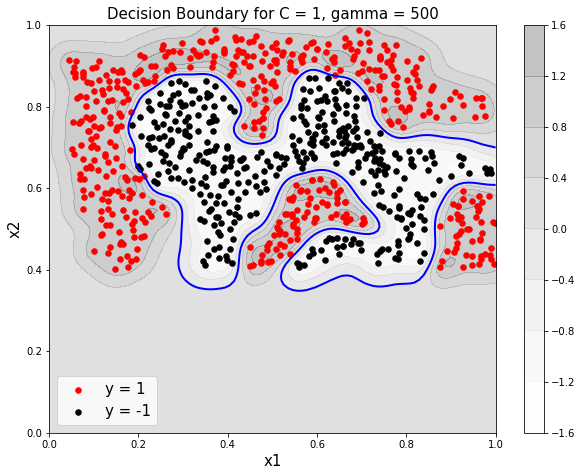

In [13]:
# Plot decision boundary for every combination of parameters:
for svm in SVMs.values():
    svm.plot_boundary()

#### Interpretation of the Above Plots

Taking a look at the primal problem, we see that the parameter $C$, controls the importance of the term $\sum_{i=1} ^{n} \zeta_i$ in the cost function, where $\zeta_i$ is the distance of the point $x_i$ from its group's margin. The larger the $C$, the harder we penalize the points having large distance from their margin. In other words, by setting $C$ to a small value, non-margin support vectors are free to get far from their corresponding margin. On the other hand, if $C$ is set to a large value, since the sum of the $\zeta_i$ appear in the cost function, they can't be too large, so the non-margin support vectors will have a small distance from their corresponding margin. $\newline$
As for the parameter $\gamma$, according to <a href="https://scikit-learn.org/">scikit-learn</a>, the $\gamma$ parameter defines how far the influence of a single training example reaches, with low values meaning ‘far’ and high values meaning ‘close’. The gamma parameters can be seen as the inverse of the radius of influence of samples selected by the model as support vectors. $\newline$
For better understanding the effect of $\gamma$, look at the following graph, which shows the output of the RBF kernel as a function of $\gamma$ for a fixed value of $||x_i - x_j||^2$. As you can see, the red curve (corresponding to $\gamma = 4$), converges to zero faster than others and in this case $x_i$ and $x_j$ must be very close to each other in order to get a non-zero output.
![gamma graph](./Kernel_Gamma.png)

As mentioned above, the parameter C controls the intensity of penalty on the points taking distance from their margin (in the opposite side). It can be seen from figures above that for a constant value of $\gamma$, as we increase C, the decision boundary becomes more complex because all the data points should have small distance from their margin. On the other hand, lowering down C results in much simpler decision boundary since the data points are free to get far from their corresponding margin. $\newline$

For a fixed value of C, when gamma is very small, the model is too constrained and cannot capture the complexity or “shape” of the data. The region of influence of any selected support vector would include the whole training set and this results in a simple decision boundary. On the other hand, setting $\gamma$ to a very large value, results in smaller area of influence for support vectors and in this case the model is prone to overfitting (complex decision boundary).

Notice that in the cases that $C=0.01$, the model is so simple that classifies all the points into positive group.

### Identification of Support Vectors

<string>:18: UserWarning: No contour levels were found within the data range.


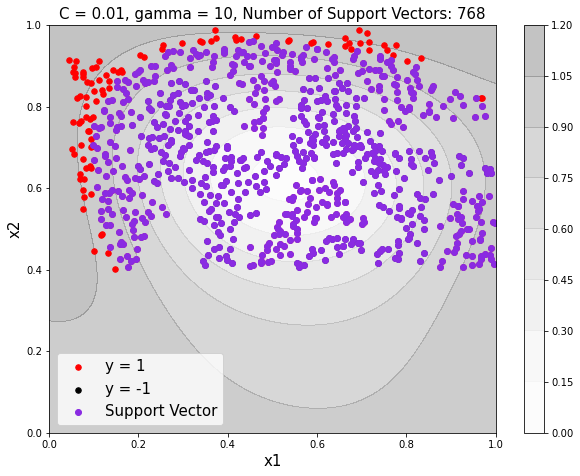

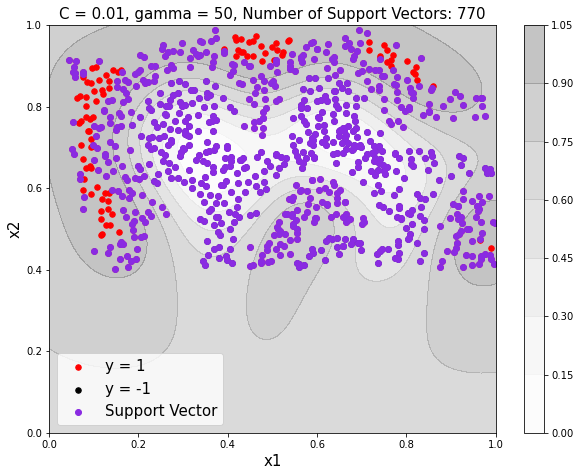

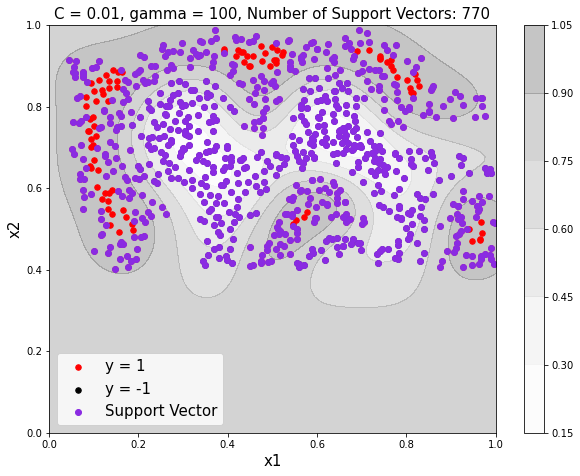

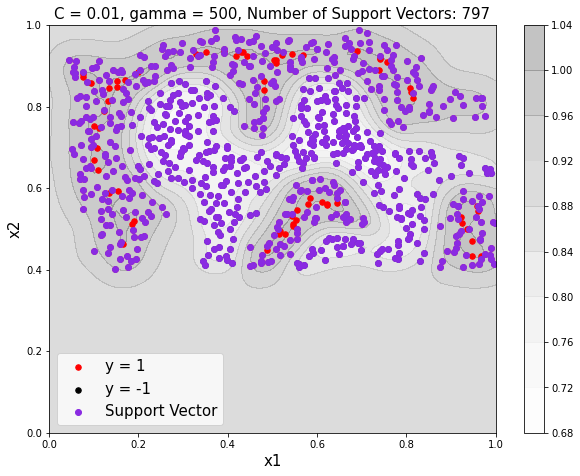

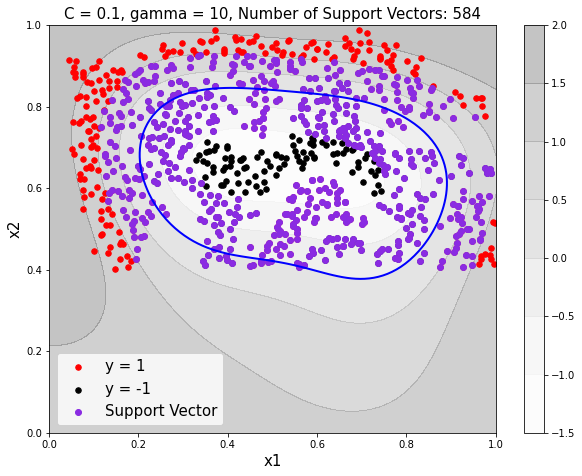

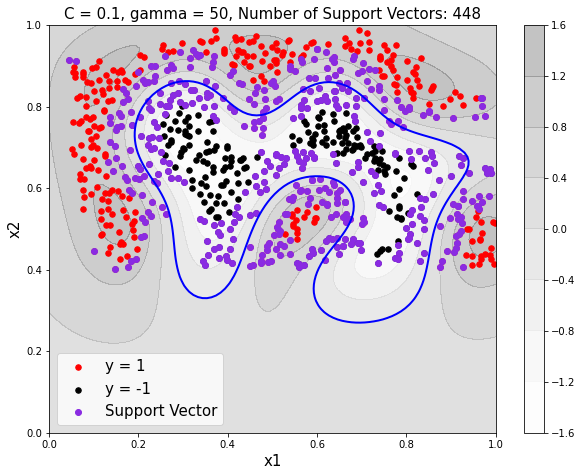

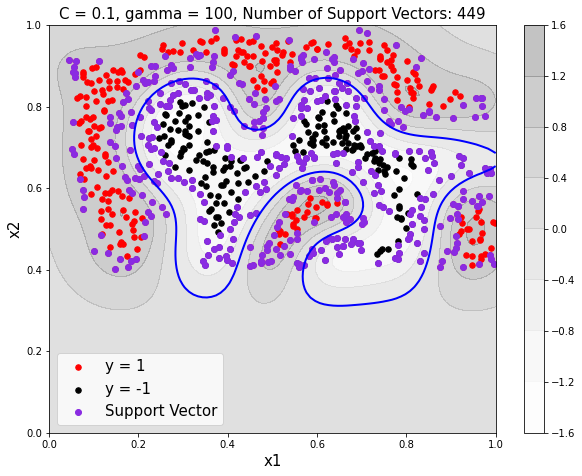

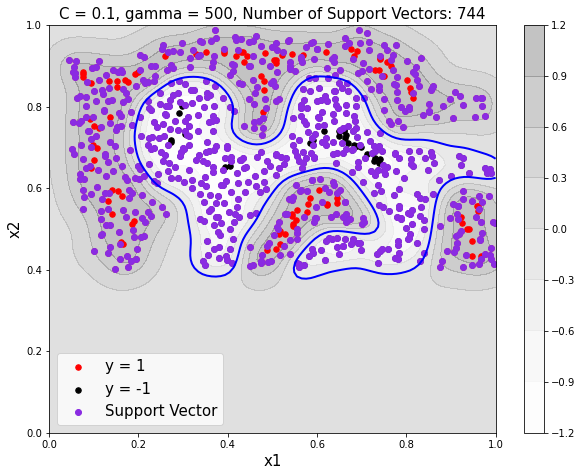

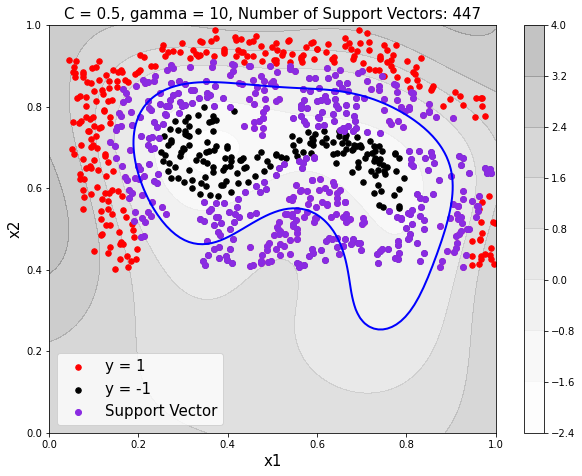

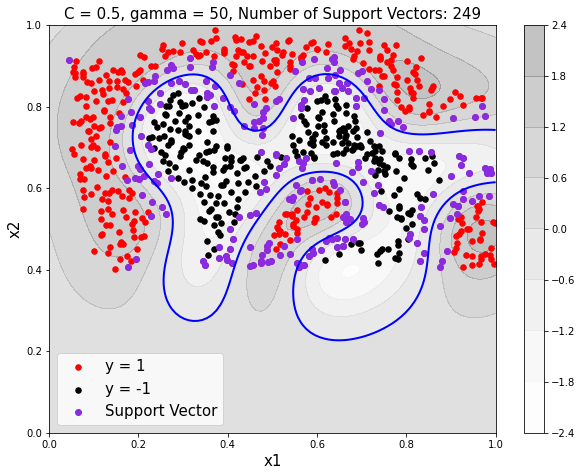

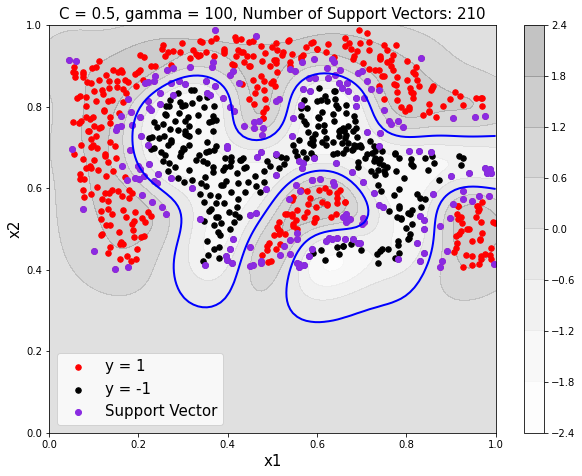

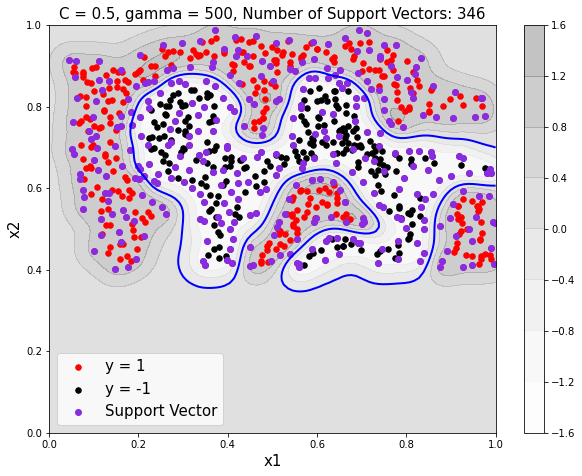

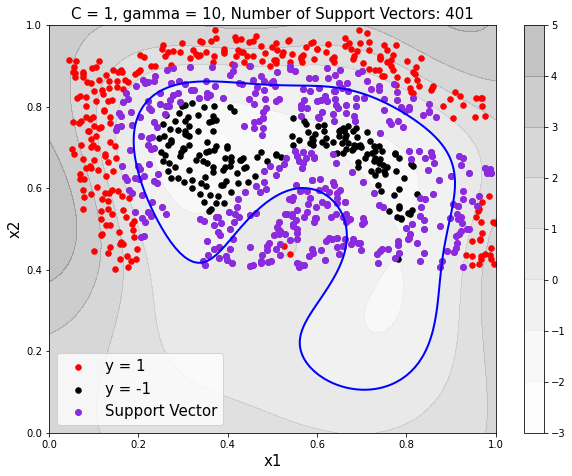

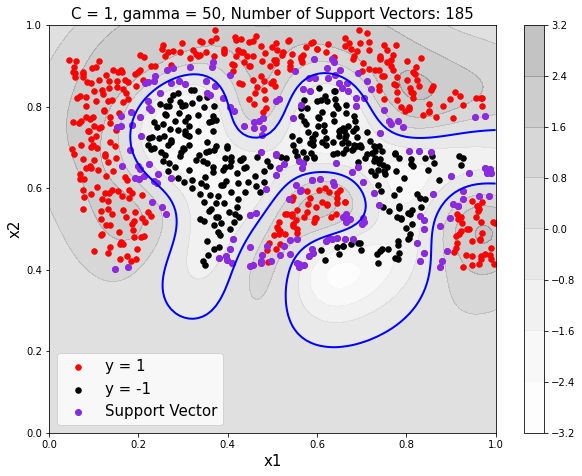

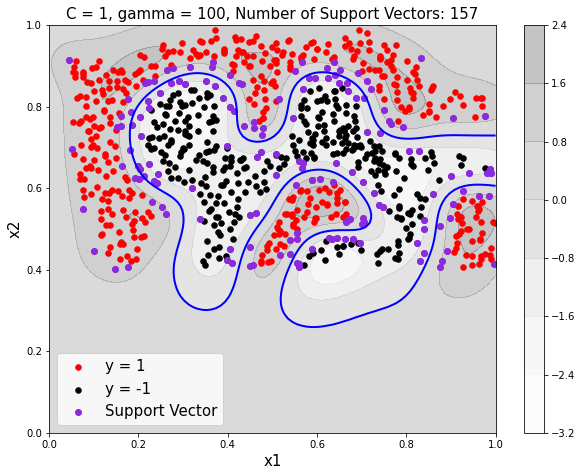

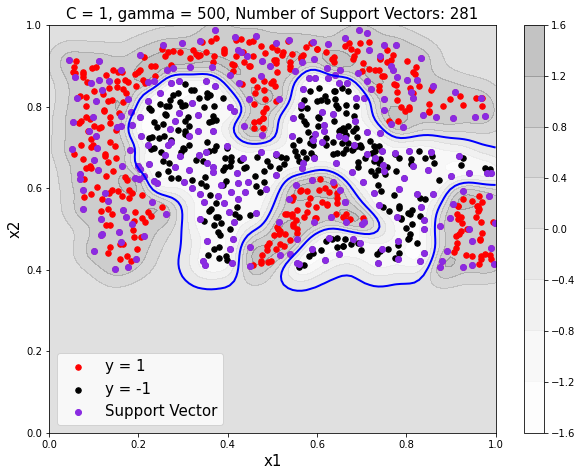

In [14]:
for svm in SVMs.values():
    svm.plot_boundary(support_vectors=True)

#### Interpretation of the Above Plots:

According to <a href="https://scikit-learn.org/">scikit-learn</a>, for some intermediate values of gamma, we get equally performing models when C becomes very large. This suggests that the set of support vectors does not change anymore. The radius of the RBF kernel alone acts as a good structural regularizer. Increasing C further doesn’t help, likely because there are no more training points in violation (inside the margin or wrongly classified), or at least no better solution can be found. Scores being equal, it may make sense to use the smaller C values, since very high C values typically increase fitting time.

On the other hand, lower C values generally lead to more support vectors, which may increase prediction time. Therefore, lowering the value of C involves a trade-off between fitting time and prediction time.

### Deriving Gradient and Hessian for Dual Problem

We saw that dual objective function can be written in the following form (in minimization format):

$$ f(\alpha) = (1/2)\alpha^TP\alpha - \textbf{1}^T\alpha $$

Where P is an n-by-n matrix defined as follows:

$$
P = 
\begin{bmatrix}
y_1y_1e^{-\gamma||x_1 - x_1||^2} & y_1y_2e^{-\gamma||x_1 - x_2||^2} & ... & y_1y_ne^{-\gamma||x_1 - x_n||^2} \\
y_2y_1e^{-\gamma||x_2 - x_1||^2} & y_2y_2e^{-\gamma||x_2 - x_2||^2} & ... & y_2y_ne^{-\gamma||x_2 - x_n||^2} \\
... & ... & ... & ... \\
y_ny_1e^{-\gamma||x_n - x_1||^2} &y_ny_2e^{-\gamma||x_n - x_2||^2} & ... & y_ny_ne^{-\gamma||x_n - x_n||^2} \\
\end{bmatrix} $$

By representing the dual objective function in this form, we can easily compute its gradient and hessian as below:

$$ \nabla_{\alpha} f(\alpha) = P\alpha - \textbf{1} $$

$$ \nabla_{\alpha}^2 f(\alpha) = P $$

In barrier method, we eliminate inequality constraints and instead add a barrier function to the objective function.
The dual original problem is: 

$$
\begin{aligned}
\textbf{minimize} \ \ \ & (1/2)\alpha^TP\alpha - \textbf{1}^T\alpha \\ 
\textbf{subject to} \ \ \ & y^T\alpha=0, \\
& \alpha_i - C \leq 0 \ \ \ i=1,...,n, \\ 
& -\alpha_i \leq 0 \ \ \ i=1,...,n
& \end{aligned}
$$

Log barrier is defined as $ -log(-f_i(x))$ for each inequality constraint $f_i(x) \leq 0$. The barrier function of this problem is as follows:

$$ g(\alpha) = -\sum_{i=1}^n [log(C-\alpha_i) + log(\alpha_i)] $$

Using this barrier function, the new synthetic problem can be written as below:

$$
\begin{aligned}
\textbf{minimize} \ \ \ & f(\alpha) + \mu g(\alpha)  \\ 
\textbf{subject to} \ \ \ & y^T\alpha=0, \\
& \end{aligned}
$$

Now all we need to do is to compute gradient and Hessian of the barrier function:

$$ \frac{\partial g}{\partial \alpha_i} = \frac{1}{C - \alpha_i} - \frac{1}{\alpha_i} $$

$$ \frac{\partial^2 g}{\partial \alpha_i \partial \alpha_j} = \left\{ \begin{array}{ll}
         \frac{1}{(c-\alpha_i)^2}+\frac{1}{\alpha_i^2} & \mbox{if $i = j$}\\
         0 & \mbox{if $i \neq j$}\end{array} \right. $$
         
so: 

$$ \nabla_{\alpha} g(\alpha) =
\begin{bmatrix}
\frac{1}{C - \alpha_1} - \frac{1}{\alpha_1} \\
... \\
\frac{1}{C - \alpha_n} - \frac{1}{\alpha_n}
\end{bmatrix}
$$

$$ \nabla_{\alpha}^2 g(\alpha) = diag ( \
\begin{bmatrix}
\frac{1}{(C-\alpha_1)^2}+\frac{1}{\alpha_1^2} \\
... \\
\frac{1}{(C-\alpha_n)^2}+\frac{1}{\alpha_n^2}
\end{bmatrix} \ )
$$

In [15]:
class BarrierOptimizer:
    
    def __init__(self, svm):
        self.svm = svm
        
        # it is efficient to calculate P once and use it forever!
        n = len(svm.y)
        z = np.diag(self.svm.X @ self.svm.X.T).reshape(-1, 1)
        X1 = np.repeat(z, n, axis=1)
        X2 = X1 + X1.T - 2* self.svm.X @ self.svm.X.T
        X3 = np.exp(-gamma * X2)
        y1 = np.reshape(self.svm.y, (-1, 1))
        self.P = (y1 @ y1.T) * X3
        
    # this function returns value of the objective function at point x
    def obj_val(self, x):
        # x: n-by-1 vector
        n = len(x)
        result = 0.5 * x.T @ self.P @ x - np.ones((n, 1)).T @ x
        result -= self.mu*np.sum(np.log(self.svm.C - x) + np.log(x))
        return float(result)
    
    # this function returns gradient of the objective function at point x
    def obj_grad(self, x):
        # x: n-by-1 vector
        n = len(x)
        result = self.P @ x - np.ones((n, 1)) + self.mu* (1/(self.svm.C - x) - 1/x)
        return result.reshape(-1, 1)
    
    # this function returns Hessian matrix of the objective function at point x
    def obj_hessian(self, x):
        # x: n-by-1 vector
        u = (1/(self.svm.C - x))**2 + (1/x)**2
        result = self.P + self.mu*np.diag(u.flatten())
        return result
    
    def backtracking_line_search(self, x, x_val, x_grad, delta_x, t_init=1, alpha=0.01, beta=0.5):
        t = t_init
        while self.obj_val(x + t*delta_x) > x_val + alpha*t*x_grad.T @ delta_x:
            t = beta*t
        return t
    
    def gradient_descent(self, x_init, stop_threshold=1e-5, verbose=False):
        n = len(self.svm.y)
        x = x_init
        while True:
            val = self.obj_val(x)
            if verbose:
                if i%10 == 0:
                    print(f'iteration: {i}, objective function value: {val}')
            grad = self.obj_grad(x)
            delta_x = -grad
            t = self.backtracking_line_search(x, val, grad, delta_x)
            x = x + t*delta_x
            new_val = self.obj_val(x)
            if np.abs(val - new_val) < stop_threshold:
                break
        
        return x
    
    def newton(self, x_init, stop_threshold=1e-5, verbose=False):
        n = len(self.svm.y)
        # choosing a random initial point
        x = x_init
        A = self.svm.y.reshape(-1, 1).T
        while True:
            hessian = self.obj_hessian(x)
            grad = self.obj_grad(x)
            val = self.obj_val(x)
            if verbose:
                if i%10 == 0:
                    print(f'iteration: {i}, objective function value: {val}')
            Z1 = np.concatenate((hessian, A), axis=0)
            Z2 = np.concatenate((A.T, np.zeros((1, 1))), axis=0)
            Z3 = np.concatenate((Z1, Z2), axis=1)
            b = np.concatenate((-grad, np.zeros((1, 1))), axis=0)
            delta_x = np.linalg.pinv(Z3) @ b
            delta_x = delta_x[:-1].reshape(-1, 1)
            t = self.backtracking_line_search(x, val, grad, delta_x)
            x = x + t*delta_x
            new_val = self.obj_val(x)
            if np.abs(val - new_val) < stop_threshold:
                break
        
        return x
    
    def plot_costs(self, iters, costs):
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(1, 1, 1)
        ax.plot(iters, costs, linewidth=2)
        ax.set_xlabel('epoch', fontsize=14)
        ax.set_ylabel('objective function value', fontsize=14)
        ax.set_title(f'final cost: {costs[-1]}', fontsize=14)
        ax.grid()
    
    def optimize(self, epsilon=1e-8, eta=0.75, mu_init=10):
        self.mu = mu_init
        n = len(self.svm.y)
        m = 2*n
        
        # choosing an initial feasible point
        x = np.zeros((n, 1))
        num_positive = np.sum(self.svm.y == 1)
        num_negative = np.sum(self.svm.y == -1)
        x[self.svm.y == 1] = self.svm.C / num_positive
        x[self.svm.y == -1] = self.svm.C / num_negative        
        
        epoch = 1
        iters = [epoch]
        costs = [self.obj_val(x)]
        t_start = time.time()
        while m*self.mu >= epsilon:
            x = self.newton(x)
            epoch += 1
            iters.append(epoch)
            costs.append(self.obj_val(x))
            self.mu = eta * self.mu
        
        t_end = time.time()
        self.svm.training_time = t_end - t_start
        self.plot_costs(iters, costs)
        self.svm.alpha = x.flatten()
        self.svm.optimal_cost = costs[-1]
        

### Solving the Problem Using Newton Method

In this part, we solve the above-mentioned problem using barrier method. To do so, we have defined BarrierOptimizer class with methods to compute objective function, gradient of the objective function and hessian of the objective function. The class also contains a function that applies backtracking line search method to determine step size in each iteration of the Newton's algorithm. Two optimization algorithms are present in this class (Newton and gradient descent) but here we just use Newton's method. We need to provide a starting point to Newton's method, and this point should lie in feasible set. For this purpose, we use the following point as the starting point of algorithm:

$$ \alpha_0 \in \textbf{R}^n $$

$$ \alpha_0[i] = \left\{ \begin{array}{ll}
         \frac{C}{\#(y \ = \ 1)} & \mbox{if $y_i = 1$}\\
         \frac{C}{\#(y \ =  \ -1)} & \mbox{if $y_i = -1$}\end{array} \right. $$
         
Where $\#(y=1)$ denotes number of data points having label of 1 and $\#(y=-1)$ denotes number of points having label of -1. This selection satisfies both constraints since all the elements of $\alpha$ are between $0$, and $C$ and we have $y^T\alpha = 0$.

About stopping rules, the method we use in Newton's algorithm is to check the value of the objective function on each iteration and if the difference of values in two consecutive iteration becomes smaller than a predefined threshold ($10^{-5}$ here), the loop breaks.

Note that setting initial $\mu$ to $10^{-4}$ gives rise to some numerical problems and to overcome this problem, initial $\mu$ is set to a larger value. Specifically, $\mu_{init} = 10$ and $\eta = 0.75$ is used to implement the barrier method.

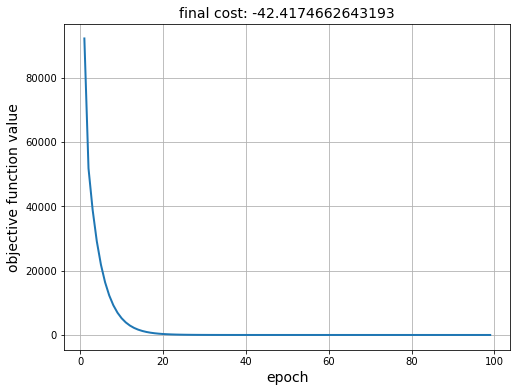

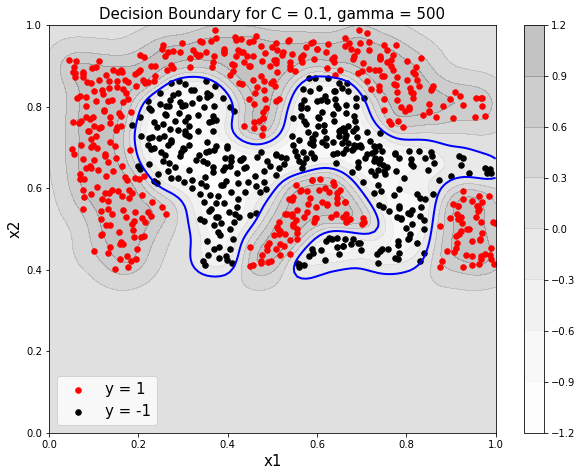

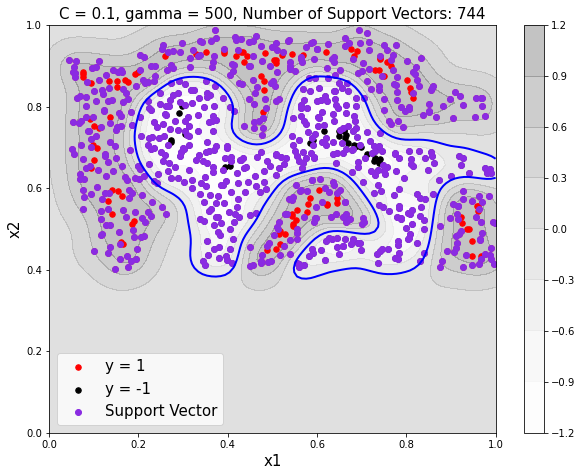

In [16]:
barrier_svm = SVM(X, y, 500, 0.1)
barrier = BarrierOptimizer(barrier_svm)
barrier.optimize()
barrier_svm.plot_boundary()
barrier_svm.plot_boundary(support_vectors=True)

### Comparison of two methods

Note that there is no test set data in this problem, and only training set error is computed.

In [17]:
%%add_to SVM

def train_accuracy(self):
    n = len(self.y)
    y_predict = np.zeros((n, ))
    
    for i in range(n):
        y_predict[i] = np.sign(self.predict(self.X[i, :]))
    
    accuracy = np.sum(self.y == y_predict)/n
    
    return accuracy

In [18]:
# SVM solved by standard CVX method
cvx_svm = SVMs[(0.1, 500)]

print(f'Solved by cvx :')
print(f'Training time: {cvx_svm.training_time} S, Training accuracy: {cvx_svm.train_accuracy()*100} %')
print(f'Optimal cost function value: {cvx_svm.optimal_cost}, Number of support vectors: {cvx_svm.num_support_vectors}')
print('-'*40)
print(f'solved by barrier method :')
print(f'training time: {barrier_svm.training_time} S, Training accuracy: {barrier_svm.train_accuracy()*100} %')
print(f'Optimal cost function value: {barrier_svm.optimal_cost}, Number of support vectors: {barrier_svm.num_support_vectors}')


Solved by cvx :
Training time: 3.373187780380249 S, Training accuracy: 99.30475086906141 %
Optimal cost function value: 42.4174664218628, Number of support vectors: 744
----------------------------------------
solved by barrier method :
training time: 29.23474407196045 S, Training accuracy: 99.30475086906141 %
Optimal cost function value: -42.4174662643193, Number of support vectors: 744


As it can be seen above, optimization time taken by cvx is 3.4 seconds and using barrier method, this number increases to 34.35 seconds which is almost 10 times greater than the time taken by cvxpy. As for training accuracy and value of cost function at optimal point and number of support vectors, there is no difference between two methods.